In [4]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import problem
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [19]:
start_state = problem.ic_flow_v_only(jnp.zeros((100,100)),None)

config_consts = {"horizontal_diffusivity": 0.1,
                "horizontal_viscosity": 0.1,
                "reference_density": 0.1,}

arg_config = ({"constants" : config_consts}, None)

In [20]:
basic_deriv = problem.vf_flow_basic(0, start_state, arg_config)

In [28]:
(basic_deriv[2] == 0).all()

Array(False, dtype=bool)

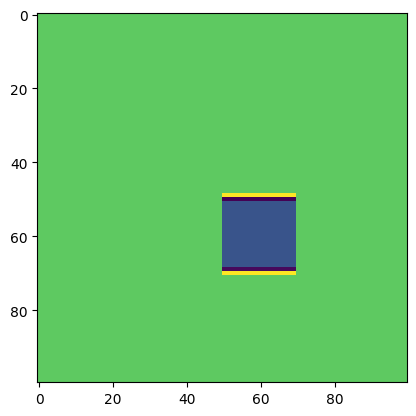

In [59]:
plt.imshow(basic_deriv[2][0])

In [36]:
basic_deriv[2][1].std()

Array(391.91837, dtype=float32)

In [45]:
velly = start_state[2]

adv_thing = problem.advection(velly, velly[1])

In [50]:
lap_vel = problem.laplacian(velly)

In [56]:
lap_vel[1]

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [46]:
adv_thing.max()

Array(0., dtype=float32)

In [47]:
velly[1].max()

Array(0., dtype=float32)